In [1]:
import torch
import torch.nn as nn
from tqdm import trange

learning_rate = 0.001

In [18]:
def conv_2_block(in_dim, out_dim):                                  # 입력 채널 수와 출력 채널 수를 인자로 받는 함수 정의
    model = nn.Sequential(                                          
        nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),       # 3x3 커널을 사용하는 2D 컨볼루션 연산 (입력 채널 -> 출력 채널)
        nn.ReLU(),                                                  # Activation Function ReLU 적용
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),      # 3x3 커널의 2D 컨볼루션 (출력 채널 유지)
        nn.ReLU(),                                                  # Activation Function ReLU 적용
        nn.MaxPool2d(2,2)                                           # 2x2 크기의 맥스 풀링을 적용하여 특성 맵 크기를 절반으로 줄임
    )
    return model                                                    # Model 반환

In [ ]:
def conv_3_block(in_dim, out_dim):                                  # 입력 채널 수와 출력 채널 수를 인자로 받는 함수 정의
    model = nn.Sequential(  
        nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),       # 첫 번째 3x3 커널 컨볼루션 (입력 채널 -> 출력 채널)
        nn.ReLU(),                                                  # Activation Function ReLU 적용
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),      # 두 번째 3x3 커널 컨볼루션 (출력 채널 유지)
        nn.ReLU(),                                                  # Activation Function ReLU 적용
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),      # 세 번째 3x3 커널 컨볼루션 (출력 채널 유지)
        nn.ReLU(),                                                  # Activation Function ReLU 적용
        nn.MaxPool2d(2,2)                                           # 2x2 크기의 맥스 풀링을 적용하여 특성 맵 크기를 절반으로 줄임
    )
    return model                                                    # Model 반환

In [ ]:
import torch.nn as nn

class VGG(nn.Module):
    def __init__(self, base_dim, num_classes=10):  # 기본 채널 수(base_dim)와 분류할 클래스 수(num_classes) input
        super(VGG, self).__init__()

        self.feature = nn.Sequential(
            conv_2_block(3, base_dim),                          # 입력 채널 3(RGB) → base_dim (64)
            conv_2_block(base_dim, 2 * base_dim),               # base_dim → 2*base_dim (128)
            conv_3_block(2 * base_dim, 4 * base_dim),           # 2*base_dim → 4*base_dim (256)
            conv_3_block(4 * base_dim, 8 * base_dim),           # 4*base_dim → 8*base_dim (512)
            conv_3_block(8 * base_dim, 8 * base_dim),           # 8*base_dim → 8*base_dim (512)
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(8 * base_dim * 1 * 1, 4096),              # 8*base_dim 채널을 가진 1x1 크기의 feature map을 4096차원으로 변환
            nn.ReLU(True),                                      # Activation Function ReLU 적용
            nn.Dropout(),                                       # 드롭아웃 적용
            nn.Linear(4096, 1000),                              # 4096차원을 1000차원으로 변환
            nn.ReLU(True),                                      # Activation Function ReLU 적용
            nn.Dropout(),                                       # 드롭아웃 적용
            nn.Linear(1000, num_classes),                       # 최종적으로 num_classes(10) 개수만큼 최종 출력
        )

    def forward(self, x):
        x = self.feature(x)                                     
        x = x.view(x.size(0), -1)                               # FC Layer에 입력하기 위해 Flatten 처리
        x = self.fc_layer(x)                                    # FC Layer을 거쳐 최종 출력 생성
        return x          

In [5]:
# device 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")     # GPU 할당

# VGG 클래스를 인스턴스화
model = VGG(base_dim=64).to(device)                                         # GPU 할당 및 

# 손실함수 및 최적화함수 설정
loss_func = nn.CrossEntropyLoss()                                           # CrossEntropyLoss 손실함수 적용
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)          # Adam Optimizrer 적용

In [6]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Transform 정의
transform = transforms.Compose(
    [transforms.ToTensor(),                                                                     # 이미지를 Tensor 형식으로 변환 (0~255 → 0~1 범위로 정규화)
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])                                   # 평균 0.5, 표준편차 0.5로 정규화

# CIFAR10 TRAIN 데이터 정의
cifar10_train = datasets.CIFAR10(root="../Data/", train=True, transform=transform, target_transform=None, download=True)

# CIFAR10 TEST 데이터 정의
cifar10_test = datasets.CIFAR10(root="../Data/", train=False, transform=transform, target_transform=None, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')      # 10개 클래스로 분류

Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified


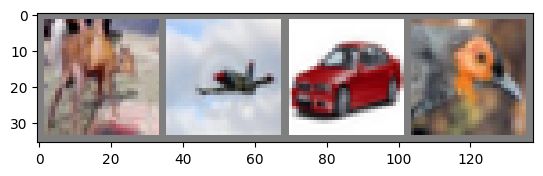

 deer plane   car  bird


In [7]:
import matplotlib.pyplot as plt
import numpy as np

train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [16]:
batch_size = 100        # Batch_size 설정 (100)
learning_rate = 0.0002  # 학습률 설정 (0.0002)
num_epoch = 100         # epochs 수 설정 (100)

In [17]:
loss_arr = []                                                 # 손실 값을 저장할 배열 초기화
for i in trange(num_epoch):                                   # 총 학습 Epochs 수만큼 반복
    for j,[image,label] in enumerate(train_loader):           # Data Loader에서 이미지와 레이블을 배치 단위로 받아옴
        x = image.to(device)                                  # 이미지를 현재 사용 중인 장치(GPU)로 이동
        y_= label.to(device)                                  # 레이블을 현재 사용 중인 장치(GPU)로 이동

        optimizer.zero_grad()                                 # Optimizer의 기울기를 0으로 초기화
        output = model.forward(x)                             # 예측 결과 계산
        loss = loss_func(output,y_)                           # 손실 계산
        loss.backward()                                       # Backpropagation Process
        optimizer.step()                                      # 가중치 업데이트

    if i % 10 ==0:                                            # 10 Epochs마다 손실 출력
        print(loss)                                           # 현재 Epoch의 손실 값 출력
        loss_arr.append(loss.cpu().detach().numpy())          # 손실 값을 배열에 저장


  1%|          | 1/100 [01:27<2:24:47, 87.76s/it]

tensor(2.2920, device='cuda:0', grad_fn=<NllLossBackward0>)


 11%|█         | 11/100 [16:06<2:10:22, 87.89s/it]

tensor(2.3217, device='cuda:0', grad_fn=<NllLossBackward0>)


 21%|██        | 21/100 [30:41<1:55:10, 87.48s/it]

tensor(2.3061, device='cuda:0', grad_fn=<NllLossBackward0>)


 31%|███       | 31/100 [45:17<1:40:39, 87.54s/it]

tensor(2.3111, device='cuda:0', grad_fn=<NllLossBackward0>)


 41%|████      | 41/100 [59:53<1:26:19, 87.78s/it]

tensor(2.2893, device='cuda:0', grad_fn=<NllLossBackward0>)


 51%|█████     | 51/100 [1:14:34<1:11:53, 88.03s/it]

tensor(2.2998, device='cuda:0', grad_fn=<NllLossBackward0>)


 61%|██████    | 61/100 [1:29:13<57:01, 87.72s/it]  

tensor(2.3084, device='cuda:0', grad_fn=<NllLossBackward0>)


 71%|███████   | 71/100 [1:43:52<42:27, 87.83s/it]

tensor(2.3180, device='cuda:0', grad_fn=<NllLossBackward0>)


 81%|████████  | 81/100 [1:58:30<27:48, 87.84s/it]

tensor(2.3111, device='cuda:0', grad_fn=<NllLossBackward0>)


 91%|█████████ | 91/100 [2:13:10<13:11, 87.95s/it]

tensor(2.3149, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 100/100 [2:26:20<00:00, 87.81s/it]


In [21]:
save_path = "vgg_model.pth"

In [22]:
torch.save(model.state_dict(), save_path)

In [24]:
# hyperparameter
batch_size = 100
learning_rate = 0.0002
save_path = "vgg_model.pth"

# device 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# VGG 클래스를 인스턴스화
model = VGG(base_dim=64).to(device)

# 저장된 모델 불러오기 
try:
    model.load_state_dict(torch.load(save_path))
    print(f"저장된 모델 {save_path} 불러오기 성공!")
except FileNotFoundError:
    print(f"저장된 모델 {save_path}을 찾을 수 없습니다. 먼저 train.py를 실행하세요.")

# 손실함수 및 최적화함수 설정
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Transform 정의
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10 TEST 데이터 정의
cifar10_test = datasets.CIFAR10(root="../Data/", train=False, transform=transform, target_transform=None, download=True)
# DataLoader 정의
test_loader = DataLoader(cifar10_test, batch_size = batch_size, shuffle=False)

# test
correct = 0  # 맞춘 개수를 저장하는 변수
total = 0  # 전체 샘플 개수를 저장하는 변수

# .eval() 호출 -> 모델이 평가 모드로 전환됨 (dropout & batchnorm 동작 방식이 달라짐)
model.eval()

# 기울기 업데이트 비활성화 (test 과정에서는 역전파가 필요 없기 때문에 실행해줘야 함) -> 연산 속도도 빨라지고, 메모리 사용량도 줄어둚
with torch.no_grad():
    # test_loader에서 batch 단위로 데이터 불러옴
    for image,label in test_loader:
        
        # GPU / CPU 로 이동시킴
        x = image.to(device)  # 입력 데이터 : (100, 3, 32, 32)
        y= label.to(device)  # 정답 데이터 : (100, )

        # output 생성
        output = model.forward(x)
        # 각 샘플에서 가장 높은 점수를 가진 클래스 인덱스 저장 -> 예측 값으로 선택하기 위해
        _,output_index = torch.max(output,1)

        # 정답 개수 & 전체 개수 업데이트
        total += label.size(0)  # 전체 개수 += 배치 크기
        correct += (output_index == y).sum().float()  # 맞춘 개수 += 예측과 정답이 같은 개수
    
    # 정확도 도출 = (맞춘 개수 / 전체 개수) * 100
    print("Accuracy of Test Data: {}%".format(100*correct/total))

저장된 모델 vgg_model.pth 불러오기 성공!
Files already downloaded and verified
Accuracy of Test Data: 10.0%


In [19]:
correct = 0
total = 0

model.eval()

# 인퍼런스 모드를 위해 no_grad 해줍니다.
with torch.no_grad():
    # 테스트로더에서 이미지와 정답을 불러옵니다.
    for image,label in test_loader:

       # 두 데이터 모두 장치에 올립니다.
        x = image.to(device)
        y = label.to(device)

        # 모델에 데이터를 넣고 결과값을 얻습니다.
        output = model.forward(x)
        _,output_index = torch.max(output,1)


        # 전체 개수 += 라벨의 개수
        total += label.size(0)
        correct += (output_index == y).sum().float()

    # 정확도 도출
    print("Accuracy of Test Data: {}%".format(100*correct/total))


Accuracy of Test Data: 10.0%
